In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
from shapely.geometry import Point
from pathlib import Path
import json
from sklearn.cluster import DBSCAN
from collections import defaultdict
import requests
import topojson as tp
import matplotlib.colors as mcolors

# PREPROCESSING

In [2]:
# df = pd.read_csv('./datasets/modis_2014_United_States.csv')
# df

In [3]:
# for year in range(2015, 2025):
#     append_df = pd.read_csv(f"./datasets/modis_{year}_United_States.csv")
#     df = pd.concat([df, append_df], ignore_index=True)

In [4]:
# df.to_csv("wildfires.csv", index=False)

In [5]:
# wildfires = pd.read_csv('./datasets/wildfires.csv')
# wildfires

In [6]:
# california = gpd.read_file(
#     "https://raw.githubusercontent.com/glynnbird/usstatesgeojson/master/california.geojson"
# )

# gdf = gpd.GeoDataFrame(
#     wildfires,
#     geometry=gpd.points_from_xy(wildfires.longitude, wildfires.latitude),
#     crs="EPSG:4326"
# )

# wildfires_ca = gdf[gdf.within(california.geometry.iloc[0])]

In [7]:
# wildfires_ca.to_csv("wildfires_ca.csv", index=False)

# INITIALIZE DATASET

In [8]:
file_path = Path.cwd() / "datasets"
csv_path = file_path / "wildfires_ca.csv"
fires = pd.read_csv(csv_path)

# FILTER DATASET

In [9]:
print(fires['confidence'].describe()) # 75%  = 100 MAX CONFIDENCE
threshold = fires['confidence'].quantile(0.75)
fires = fires[fires['confidence'] >= threshold]

count    196496.000000
mean         74.988651
std          25.110790
min           0.000000
25%          58.000000
50%          81.000000
75%         100.000000
max         100.000000
Name: confidence, dtype: float64


In [10]:
fires

,latitude,longitude,brightness,scan,track,acq_date,acq_time,satellite,instrument,confidence,version,bright_t31,frp,daynight,type,geometry
5,40.0657,-121.7420,340.3,1.4,1.2,2014-01-03,950,Aqua,MODIS,100,6.20,284.1,80.1,N,0,POINT (-121.742 40.0657)
24,40.8055,-123.7886,376.9,1.3,1.1,2014-01-04,2138,Aqua,MODIS,100,6.20,292.1,201.5,D,0,POINT (-123.7886 40.8055)
25,40.8039,-123.8035,385.8,1.3,1.1,2014-01-04,2138,Aqua,MODIS,100,6.20,295.7,254.6,D,0,POINT (-123.8035 40.8039)
76,39.2651,-122.2245,384.6,1.3,1.1,2014-01-10,2101,Aqua,MODIS,100,6.20,289.7,248.2,D,0,POINT (-122.2245 39.2651)
112,36.2085,-118.5341,340.4,1.0,1.0,2014-01-15,600,Terra,MODIS,100,6.20,281.4,49.2,N,0,POINT (-118.5341 36.2085)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
196418,34.0394,-118.6635,328.4,2.2,1.5,2024-12-10,1112,Aqua,MODIS,100,61.03,288.2,94.8,N,3,POINT (-118.6635 34.0394)
196450,34.0534,-118.7243,350.7,2.0,1.4,2024-12-11,1014,Aqua,MODIS,100,61.03,270.2,190.5,N,0,POINT (-118.7243 34.0534)
196452,34.0557,-118.7157,350.9,2.0,1.4,2024-12-11,1014,Aqua,MODIS,100,61.03,270.7,192.9,N,0,POINT (-118.7157 34.0557)
196460,38.7241,-119.8206,364.9,1.0,1.0,2024-12-12,2155,Aqua,MODIS,100,61.03,277.0,104.7,D,0,POINT (-119.8206 38.7241)


In [11]:
json_path = file_path / "fires.json"
# fires.to_json(json_path, orient="records", indent=2)

In [12]:
dates = sorted(fires['acq_date'].unique())
date_path = file_path / "dates.json"
# with open(date_path, "w") as f:
#     json.dump(dates, f, indent=2)

# MAKE PLOT

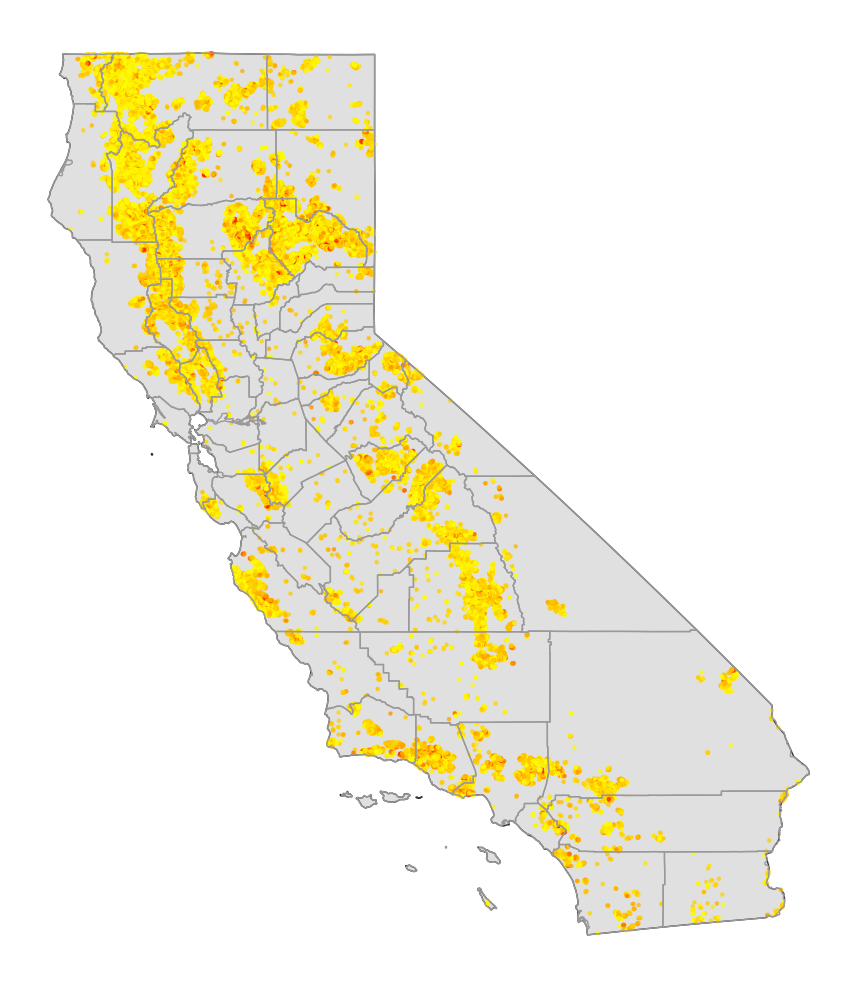

In [21]:
california = gpd.read_file(
    "https://raw.githubusercontent.com/glynnbird/usstatesgeojson/master/california.geojson"
)

ca_counties_gdf = gpd.read_file(
    "https://raw.githubusercontent.com/codeforamerica/click_that_hood/master/public/data/california-counties.geojson"
)

ca_counties_gdf = ca_counties_gdf.to_crs("EPSG:4326")

fires['acq_date'] = pd.to_datetime(fires['acq_date'])

fire_gdf = gpd.GeoDataFrame(
    fires,
    geometry=gpd.points_from_xy(fires.longitude, fires.latitude),
    crs="EPSG:4326"
)

brightness = fire_gdf['brightness'].astype(float)
min_bright, max_bright = brightness.min(), brightness.max()
mid_bright = (min_bright + max_bright)/2

cmap = mcolors.LinearSegmentedColormap.from_list(
    "fire_cmap",
    [(0, "yellow"), (0.5, "orange"), (1, "red")]
)

norm = mcolors.Normalize(vmin=min_bright, vmax=max_bright)



fig, ax = plt.subplots(figsize=(10, 10))

# Plot the California state boundary (optional, for context)
california.plot(ax=ax, color='#e0e0e0', edgecolor='#333')

# Plot county boundaries
ca_counties_gdf.boundary.plot(ax=ax, edgecolor='#999', linewidth=1)

# Plot the fires
fire_gdf.plot(ax=ax, markersize=5, alpha=0.7, color=[cmap(norm(val)) for val in fire_gdf['brightness']])

# Optional: titles and labels
# plt.title("All California Fires From 2014-2024")
# plt.xlabel("Longitude")
# plt.ylabel("Latitude")

ax.axis('off')

plt.tight_layout()
plt.show()

# MAKE CLUSTERS PER CITY

In [14]:
ca_counties_gdf = gpd.read_file(
    "https://raw.githubusercontent.com/codeforamerica/click_that_hood/master/public/data/california-counties.geojson"
)

ca_counties_gdf = ca_counties_gdf.to_crs("EPSG:4326")

fires['acq_date'] = pd.to_datetime(fires['acq_date'])

fire_gdf = gpd.GeoDataFrame(
    fires,
    geometry=gpd.points_from_xy(fires.longitude, fires.latitude),
    crs="EPSG:4326"
)

In [15]:
county_fire_counts = {}

all_dates = pd.date_range(
    fires['acq_date'].min(),
    fires['acq_date'].max()
)

for date in all_dates:
    day_fires = fire_gdf[fire_gdf['acq_date'] == date]
    counts = [
        int(day_fires.within(geom).sum())
        for geom in ca_counties_gdf.geometry
    ]
    county_fire_counts[date.strftime("%Y-%m-%d")] = counts

In [16]:
json_path2 = file_path / "fire_counties.json"
# with open(json_path2, "w") as f:
#     json.dump(county_fire_counts, f, indent=2)

# GET COUNTY NAMES

In [17]:
county_names = list(ca_counties_gdf['name'])
json_path3 = file_path / "county_names.json"
# with open(json_path3, "w") as f:
#     json.dump(county_names, f, indent=2)

# CUMULATIVE COUNTS

In [18]:
# with open(json_path2) as f:
#     daily_counts = json.load(f)

# dates = sorted(daily_counts.keys())

# cumulative = {}

# running_total = None

# for date in dates:
#     today = np.array(daily_counts[date], dtype=int)

#     if running_total is None:
#         running_total = today
#     else:
#         running_total = running_total + today

#     cumulative[date] = running_total.tolist()

In [19]:
json_path4 = file_path / "cumulative.json"
# with open(json_path4, "w") as f:
#     json.dump(cumulative, f, indent=2)